# Projeto com Feedback 7

## Medicina Personalizada - Redefinindo o Tratamento de Câncer

### Rosane Moreira Barbosa

In [1]:
# Importando pacotes

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 1 - Carregando os Dados

### 1.1 - Carregando os dados das informações sobre as mutações genéticas

In [2]:
# Carregando os dados de treino
df_treino_variantes = pd.read_csv('data/training_variants')

In [3]:
# Visualizando os dados
df_treino_variantes.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# Shape dos dados
df_treino_variantes.shape

(3321, 4)

In [5]:
# Verificando se existem dados missing
df_treino_variantes.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

### 1.2 - Carregando os dados da evidência clínica (texto) usada para classificar as mutações genéticas

In [6]:
# Carregando os dados de treino
df_treino_texto = pd.read_csv('data/training_text',
                              sep = '\|\|',
                              engine = 'python',
                              names = ['ID', 'Texto'], 
                              skiprows = 1)

In [7]:
# Visualizando os dados
df_treino_texto.head()

,ID,Texto
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
# Shape dos dados
df_treino_texto.shape

(3321, 2)

In [9]:
# Verificando se existem dados missing
df_treino_texto.isnull().sum()

ID       0
Texto    5
dtype: int64

### 1.3 - Merge dos Arquivos de Dados

In [10]:
# Merge dos arquivos pelo ID
df_treino = pd.merge(df_treino_variantes, df_treino_texto, on = 'ID', how = 'left')

In [11]:
# Visualizando o merge dos dados de treino
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [12]:
# Shape dos dados
df_treino.shape

(3321, 5)

In [13]:
# Verificando se há dados missing após o merge
df_treino.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Texto        5
dtype: int64

In [14]:
# listando os dados missing (NaN)
df_treino[df_treino.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,Texto
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [15]:
# Tipo das variáveis
df_treino.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Texto        object
dtype: object

## 2 - Análise Exploratória dos Dados

In [16]:
# Contando o número de Genes
# Verifica-se que o arquivo contém 264 tipos de Genes
df_treino.Gene.value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
TCF7L2      1
SDHB        1
CDK8        1
RYBP        1
FGF19       1
Name: Gene, Length: 264, dtype: int64

In [17]:
# Verificando o total de valores únicos de Genes
df_treino.Gene.nunique()

264

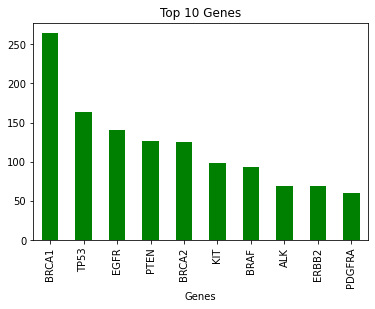

In [18]:
# Gráfico dos top 10 Genes
treino_ten_genes = df_treino['Gene'].value_counts().head(10)

treino_ten_genes.plot(kind = 'bar', color = 'green')
plt.xlabel('Genes')
plt.title('Top 10 Genes')
plt.show()

In [19]:
# Contando o número de variações 
# Verifica-se que o arquivo contém 2.996 tipos de variações
df_treino['Variation'].value_counts()

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
L57del                   1
R201H                    1
G199R                    1
N553S                    1
D3095E                   1
Name: Variation, Length: 2996, dtype: int64

In [20]:
# Verificando o total de valores únicos de Variation
df_treino.Variation.nunique()

2996

In [21]:
# Contando a quantidade de Class (classificação da mutação genética) por Gene
df_treino.groupby(by = ['Gene'])['Class'].value_counts()

Gene   Class
ABL1   2        24
       7         2
ACVR1  7         2
       2         1
AGO2   1         4
                ..
XPO1   2         1
       6         1
XRCC2  1         2
YAP1   2         3
       7         1
Name: Class, Length: 590, dtype: int64

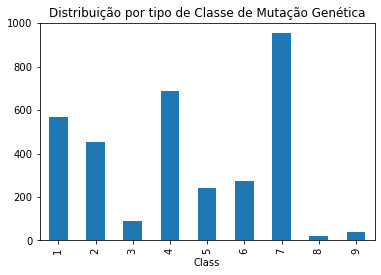

In [22]:
# Gráfico da distribuição de dados por tipo de Class
treino_class = df_treino['Class'].value_counts().sort_index()

treino_class.plot(kind = 'bar')
plt.xlabel('Class')
plt.title('Distribuição por tipo de Classe de Mutação Genética')
plt.show()

De acordo com o gráfico acima da distribuição de classe, verificamos que variável Class é desbalanceada (as classes 7, 4, 1 e 2 concentram mais observações do que as demais).

## 3 - Pré-Processamento dos Dados

### 3.1 - Preparando o Texto (Tokenization, Lemmatization, remoção de Pontuação e Stopwords)

In [23]:
# Importando pacotes de PLN (Processamento de Linguagem Natural)

import re
import nltk
import spacy
import string
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from datetime import datetime

import warnings
warnings.filterwarnings(action = "ignore", category = FutureWarning)
# warnings.filterwarnings("ignore", category = DeprecationWarning)

Using TensorFlow backend.


In [24]:
# Converte Texto para o tipo string
df_treino['Texto'] = df_treino['Texto'].astype('str')

In [25]:
# Função para remover caracteres non-ascii
def removeNoAscii(s):
    return "".join(i for i in s if ord(i) < 128)

In [26]:
# Remove caracteres non-ascii
df_treino['Texto'] = df_treino['Texto'].map(lambda x: removeNoAscii(x))

In [27]:
# Carrega o dicionário em Inglês na sessão SpaCy
nlp = spacy.load('en_core_web_sm')

In [28]:
# Função para remover pontuação e lematizar
def limpa_texto(text):
    
    # Remove pontuação usando expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    
    # Usa o SpaCy para lematização
    doc = nlp(nopunct, disable = ['parser', 'ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

In [29]:
# Aplica a função
start = datetime.now()
df_treino['Texto'] = df_treino['Texto'].map(limpa_texto)
print('Tempo Total para Limpar o Texto :', datetime.now() - start)

Tempo Total para Limpar o Texto : 0:36:32.396982


In [30]:
# Transforma o Texto em minúsculo
df_treino['Texto'] = df_treino['Texto'].map(lambda x: [word.lower() for word in x])

In [31]:
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"[cyclin, dependent, kinase, , cdk, , regulat..."
1,1,CBL,W802*,2,"[ , abstract, background, , non, small, cell,..."
2,2,CBL,Q249E,2,"[ , abstract, background, , non, small, cell,..."
3,3,CBL,N454D,3,"[recent, evidence, have, demonstrate, that, ac..."
4,4,CBL,L399V,4,"[oncogenic, mutation, in, the, monomeric, casi..."


In [32]:
# Função para remover stopwords
english_stops = set(stopwords.words('english'))

def remove_stopwords(text):
    return [word for word in text if word not in english_stops]

In [33]:
# Aplica a função para remover stopwords do texto
df_treino['Texto'] = df_treino['Texto'].map(lambda x: remove_stopwords(x))

In [34]:
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"[cyclin, dependent, kinase, , cdk, , regulat..."
1,1,CBL,W802*,2,"[ , abstract, background, , non, small, cell,..."
2,2,CBL,Q249E,2,"[ , abstract, background, , non, small, cell,..."
3,3,CBL,N454D,3,"[recent, evidence, demonstrate, acquire, unipa..."
4,4,CBL,L399V,4,"[oncogenic, mutation, monomeric, casitas, b, l..."


In [35]:
# Função para remover espaços em branco
def remove_espaco(text):
    return [word for word in text if word != " "]

In [36]:
# Aplica a função para remover espaços em branco do texto
df_treino['Texto'] = df_treino['Texto'].map(lambda x: remove_espaco(x))

In [37]:
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"[cyclin, dependent, kinase, cdk, regulate, var..."
1,1,CBL,W802*,2,"[abstract, background, non, small, cell, lung,..."
2,2,CBL,Q249E,2,"[abstract, background, non, small, cell, lung,..."
3,3,CBL,N454D,3,"[recent, evidence, demonstrate, acquire, unipa..."
4,4,CBL,L399V,4,"[oncogenic, mutation, monomeric, casitas, b, l..."


In [38]:
# Converte a lista de Texto para string
df_treino['Texto'] = df_treino['Texto'].astype(str)

In [39]:
df_treino.head()

,ID,Gene,Variation,Class,Texto
0,0,FAM58A,Truncating Mutations,1,"['cyclin', 'dependent', 'kinase', 'cdk', 'regu..."
1,1,CBL,W802*,2,"['abstract', 'background', 'non', 'small', 'ce..."
2,2,CBL,Q249E,2,"['abstract', 'background', 'non', 'small', 'ce..."
3,3,CBL,N454D,3,"['recent', 'evidence', 'demonstrate', 'acquire..."
4,4,CBL,L399V,4,"['oncogenic', 'mutation', 'monomeric', 'casita..."


In [40]:
# Join das variáveis preditoras
df_treino['GenVarText'] = df_treino[['Gene', 'Variation','Texto']].apply(lambda x: " ".join(x), axis=1)

In [41]:
# Cria objeto tokenizer
num_max_words = 2000
tokenizer = Tokenizer(num_words = num_max_words)

In [42]:
df_treino.head()

,ID,Gene,Variation,Class,Texto,GenVarText
0,0,FAM58A,Truncating Mutations,1,"['cyclin', 'dependent', 'kinase', 'cdk', 'regu...","FAM58A Truncating Mutations ['cyclin', 'depend..."
1,1,CBL,W802*,2,"['abstract', 'background', 'non', 'small', 'ce...","CBL W802* ['abstract', 'background', 'non', 's..."
2,2,CBL,Q249E,2,"['abstract', 'background', 'non', 'small', 'ce...","CBL Q249E ['abstract', 'background', 'non', 's..."
3,3,CBL,N454D,3,"['recent', 'evidence', 'demonstrate', 'acquire...","CBL N454D ['recent', 'evidence', 'demonstrate'..."
4,4,CBL,L399V,4,"['oncogenic', 'mutation', 'monomeric', 'casita...","CBL L399V ['oncogenic', 'mutation', 'monomeric..."


In [43]:
# Conferindo se ainda há valores missing
df_treino['GenVarText'].isnull().any()

False

In [44]:
# Tokenizer
tokenizer.fit_on_texts(df_treino['GenVarText'].values)

In [45]:
# Converte para sequência
sequencia_treino = tokenizer.texts_to_sequences(df_treino['GenVarText'].values)

In [46]:
# Preenche a sequência
X = pad_sequences(sequencia_treino, maxlen = num_max_words)

In [47]:
X.shape

(3321, 2000)

### 3.2 - Divisão dos Dados em Treino e Teste

In [48]:
# Importando módulo do SKlearn
from sklearn.model_selection import train_test_split

In [49]:
# Cria variável dummy target (Class)
y = pd.get_dummies(df_treino['Class']).values

In [50]:
y.shape

(3321, 9)

In [51]:
# Dividindo os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 5)

In [52]:
# Shape dos dados de treino
print(X_treino.shape)
print(y_treino.shape)

(2988, 2000)
(2988, 9)


In [53]:
# Shape dos dados de teste
print(X_teste.shape)
print(y_teste.shape)

(333, 2000)
(333, 9)


## 4 - Construção do Modelo de Deep Learning

In [54]:
# Importando pacotes do Keras

import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Dropout, LSTM, SpatialDropout1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings(action = "ignore", category = FutureWarning)
warnings.filterwarnings(action = "ignore", category = DeprecationWarning)

### Modelo de Rede Neural LSTM (Long Short Term Memory)

In [56]:
# Modelo LSTM 

# Cria o objeto sequencial
modelo_lstm = Sequential()

# Primeira camada para receber os dados de entrada
modelo_lstm.add(Embedding(input_dim = num_max_words, output_dim = 128, input_length = X.shape[1]))
modelo_lstm.add(SpatialDropout1D(0.3))

# Segunda camada de LSTM
modelo_lstm.add(LSTM(196, dropout = 0.3, recurrent_dropout = 0.3))

# Terceira camada oculta com ativação ReLu
modelo_lstm.add(Dense(196, activation = 'relu'))

# Dropout para evitar Overfitting
modelo_lstm.add(Dropout(0.3))

# Última camada com ativação Softmax
modelo_lstm.add(Dense(9, activation = 'softmax'))

print(modelo_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 2000, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 196)               38612     
_________________________________________________________________
dropout_2 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1773      
Total params: 551,185
Trainable params: 551,185
Non-trainable params: 0
_________________________________________________________________
None

In [57]:
# Compilando o modelo com a função de perda de entropia cruzada, otimizador Adam (utiliza o gradiente descendente)
# e a métrica acurácia. 

modelo_lstm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [58]:
# Salvando modelo callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='max')

In [59]:
# Hiperparâmetros
epochs = 8
batch_size = 32

O treinamento ocorre através de épocas (epochs) e cada época é dividida em lotes (batch), onde uma época é uma passagem por todas as linhas do conjunto de dados de treinamento e um lote é composto de uma ou mais amostras consideradas pelo modelo em uma época antes que seja feita a atualização dos pesos.

In [60]:
# Teinamento do modelo LSTM, reservando 20% dos dados para validação
start = datetime.now()
history1 = modelo_lstm.fit(X_treino, y_treino, validation_split = 0.2, epochs = epochs, batch_size = batch_size,  callbacks=[ckpt_callback])
print('Tempo Total de Treinamento :', datetime.now() - start)

Instructions for updating:
Use tf.cast instead.
Train on 2390 samples, validate on 598 samples
Epoch 1/8
2390/2390 [==============================] - 383s 160ms/step - loss: 1.9027 - acc: 0.2862 - val_loss: 1.7698 - val_acc: 0.4264
Epoch 2/8
2390/2390 [==============================] - 395s 165ms/step - loss: 1.5193 - acc: 0.4406 - val_loss: 1.4025 - val_acc: 0.4967
Epoch 3/8
2390/2390 [==============================] - 392s 164ms/step - loss: 1.2366 - acc: 0.5339 - val_loss: 1.3166 - val_acc: 0.5201
Epoch 4/8
2390/2390 [==============================] - 391s 164ms/step - loss: 1.0768 - acc: 0.6067 - val_loss: 1.3103 - val_acc: 0.5552
Epoch 5/8
2390/2390 [==============================] - 398s 167ms/step - loss: 0.9620 - acc: 0.6586 - val_loss: 1.3117 - val_acc: 0.5719
Epoch 6/8
2390/2390 [==============================] - 397s 166ms/step - loss: 0.8802 - acc: 0.6874 - val_loss: 1.3466 - val_acc: 0.5468
Epoch 7/8
2390/2390 [==============================] - 392s 164ms/step - loss: 0.81

In [61]:
print('Loss em validação:', history1.history['val_loss'][-1])
print('Acurácia em validação:', history1.history['val_acc'][-1])

Loss em validação: 1.3681484951223417
Acurácia em validação: 0.5735785943209926


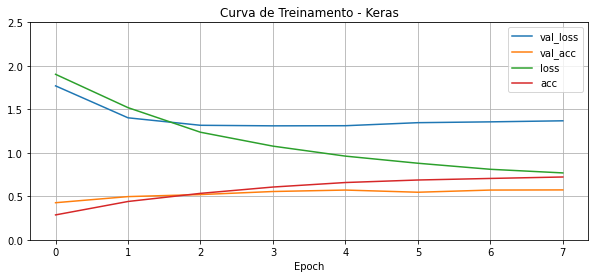

In [62]:
# Plot do histórico de treinamento - Loss e Accuracy
pd.DataFrame(history1.history).plot(figsize = (10, 4))
plt.grid(True)
plt.gca().set_ylim(0, 2.5)
plt.title("Curva de Treinamento - Keras")
plt.xlabel("Epoch")
plt.show()

## 5 - Previsão com Dados de Teste

In [63]:
import scikitplot.plotters as skplt

In [64]:
# Avaliação da previsão do modelo para os dados de teste
score = modelo_lstm.evaluate(X_teste, y_teste, verbose = 1)

print('Loss:', score[0])
print('Acurácia:', score[1])

333/333 [==============================] - 6s 17ms/step
Loss: 1.3909341411905605
Acurácia: 0.540540540630037


In [65]:
# Previsões com dados de teste
y_pred = modelo_lstm.predict(X_teste)

In [66]:
# Prever as probabilidades para a variável Class
y_prob = modelo_lstm.predict_proba(X_teste)

333/333 [==============================] - 6s 17ms/step


In [67]:
pred_indices = np.argmax(y_pred, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]                   

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

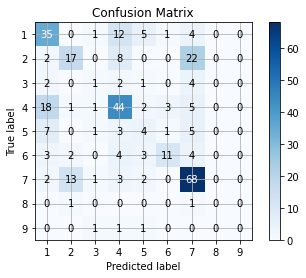

In [68]:
# Confusion Matrix
skplt.plot_confusion_matrix(classes[np.argmax(y_teste, axis=1)], preds)

### Conclusão:

Verifica-se na diagonal da matriz, acima, que as classes com mais observações (classes 7, 4, 1 e 2) foram as que apresentaram maiores acertos na previsão. Para melhorar a precisão do modelo teríamos que obter mais dados das demais classes.

In [69]:
# Visualizando as probabilidades das classes para os 10 primeiros registros
pred = pd.DataFrame(y_prob)
pred.columns = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9']
pred.head(10)

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9
0,0.021481,0.074914,0.199646,0.042042,0.158794,0.071921,0.176847,5.883734e-02,1.955169e-01
1,0.833854,0.025717,0.002040,0.044389,0.035862,0.014752,0.041594,7.843227e-04,1.007462e-03
2,0.005037,0.425032,0.011678,0.005618,0.040817,0.021512,0.486593,1.494723e-03,2.218341e-03
3,0.005408,0.022934,0.377974,0.020084,0.101992,0.017635,0.251412,4.119535e-02,1.613664e-01
4,0.031670,0.094114,0.088082,0.019393,0.261264,0.072238,0.360808,2.209647e-02,5.033258e-02
5,0.000027,0.054266,0.000137,0.000035,0.000736,0.000038,0.944760,7.348621e-07,5.746048e-07
6,0.001822,0.002222,0.027078,0.105275,0.030989,0.818838,0.000921,1.415615e-03,1.143822e-02
7,0.011361,0.251307,0.008979,0.009877,0.028780,0.010473,0.676716,1.269601e-03,1.237127e-03
8,0.000497,0.776713,0.006567,0.004064,0.008555,0.009666,0.192743,4.605461e-04,7.344575e-04
9,0.104811,0.317935,0.006022,0.228184,0.020982,0.052692,0.266189,1.519645e-03,1.666539e-03


## Fim